In [54]:
import numpy as np
import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pandas as pd

In [120]:
a=np.zeros((100,2))
a[10]=np.array([1,2])
a[10]

array([1., 2.])

In [135]:
##========================================================data by pythia
_e,_pt,_eta,_phi,_logpt,_loge=0,1,2,3,4,5
def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def deltaR(eta1,phi1,eta2,phi2):
    return (deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)**0.5

def find_main_axis(clist):
    def fcn(p):
        dir_x,dir_y = np.cos(p[0]),np.sin(p[0])
        v = clist[(clist[:,_eta]**2+clist[:,_phi]**2)**0.5>1E-5]
        cosang = np.abs(dir_x*v[:,_eta]+dir_y*v[:,_phi])/(v[:,_eta]**2+v[:,_phi]**2)**0.5
        proj = (v[:,_pt]*cosang).sum()
        return -proj
    r = opt.minimize(fcn,[0.])
    if r.success: return r.x[0]
    else: return None
def parse_jet_data(fin):
    
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    
    data = {}
#     features_list = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['e'] = float(buf[0])
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist, mask, features, points = [],np.zeros((100,1)), np.zeros((100,4)), np.zeros((100,2)) # prepare constituents list
    if (data['nconstituents']<=100):
        for i in range(data['nconstituents']):  ##particlenet need to be 100
            #         _pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
            var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
            var_logpt = np.log(var[_pt])
            var_loge = np.log(var[_e])
            var[_eta] = var[_eta]-data['eta']
            var[_phi] = deltaPhi(var[_phi],data['phi'])
            mask[i]=np.array([var_logpt])
            features[i]=np.array([var_logpt,var_loge,var[_eta],var[_phi]])
            points[i]=np.array([var[_eta],var[_phi]])
    else:
        for i in range(data['nconstituents']):
            fin.readline().decode().split()
       

#     clist = np.array(clist)
#     features_list['mask']=np.array(mask)
#     features_list['points']=np.array(points)
#     features_list['features']=np.array(features)
#     dir = find_main_axis(clist) ##rotation
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]

    
    return mask.tolist(), features.tolist(), points.tolist()
def prepare(n,fin):
    fin=gzip.open(fin)
    features_list = {}
    mask, features, points = [],[],[]
    for i in range(n):
        a, b, c  = parse_jet_data(fin)
        mask.append(a)
        features.append(b)
        points.append(c)
    features_list['mask']=mask
    features_list['points']=points
    features_list['features']=features
    return features_list
    
def separatedata(features_list,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = features_list["mask"]
    features = features_list["features"]
    points = features_list["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test) 
def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

In [137]:
eventg, eventq = './myeventsgg.txt.gz', './myeventsgg.txt.gz'
n=1000
gg = prepare(n,eventg)
qq = prepare(n,eventq)
y=[[1,0] for i in range(len(gg['mask']))]+[[0,1] for i in range(len(qq['mask']))] ##?????????????????
total = merging(gg,qq)

In [138]:
del gg, qq, eventg, eventq
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(total,y,0.1,0.1)

In [65]:


import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [95]:
##self

model_type = 'particle_net_lite'
input_shapes={'points': (100, 2), 'features': (100, 4), 'mask': (100, 1)}
num_classes = 2
model = get_particle_net(num_classes, input_shapes)

In [96]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [97]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [33]:
# if 'lite' in model_type:
#     model = get_particle_net_lite(num_classes, input_shapes)
# else:
#     model = get_particle_net(num_classes, input_shapes)

In [98]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2020-03-05 23:05:04,205] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ParticleNet_7/NotEq [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_ParticleNet_7/Cast  [(None, 100, 1)]     0           tf_op_layer_ParticleNet_7/NotEqua
__________________________________________________________________________________________________
tf_op_layer_ParticleNet_7/Equal [(None, 100, 1)]     0           tf_op_layer_ParticleNet_7/Cast[0]
________________________________________________________________________________________

In [103]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.test.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [131]:
total["points"].shape

(1000, 100, 2)

In [104]:
y_train=np.array(y_train)
y_val=np.array(y_val)
for i in X_train:
    X_train[i]=np.array(X_train[i])
    X_test[i]=np.array(X_test[i])
    X_val[i]=np.array(X_val[i])

In [61]:
pd.DataFrame(X_train["points"]).iloc()

In [ ]:
# train_dataset.shuffle()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=20, # --- train only for 1 epoch here for demonstration ---
          validation_data=(X_val, y_val),
          shuffle=True,
          callbacks=callbacks)
model.evaluate(X_test,  y_test, verbose=2)

[2020-03-05 23:25:19,595] INFO: Learning rate: 0.001000


Train on 1600 samples, validate on 200 samples
Epoch 1/20
Epoch 1/20


In [140]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

array([0.5153372 , 0.52196693, 0.52905613, 0.5220585 , 0.52667   ,
       0.5289552 , 0.5332695 , 0.527051  , 0.529075  , 0.5261348 ],
      dtype=float32)

The area under the curves are:
AUC:0.494322179


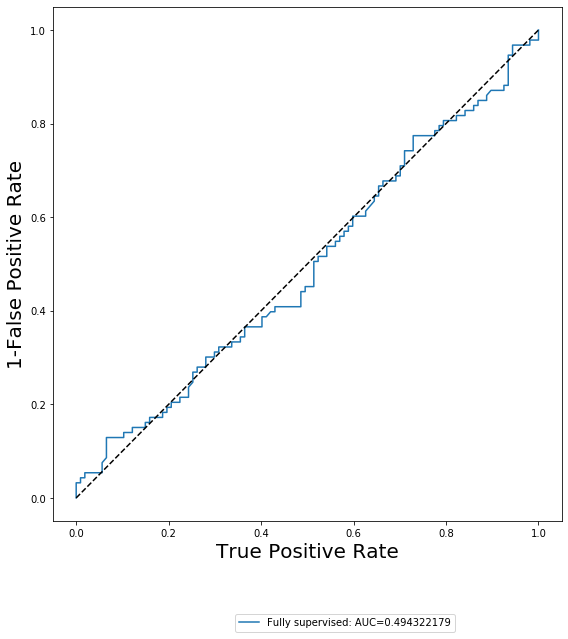

In [145]:
# y_test=[i[1] for i in testpojen_datay]
y_score=model.predict(X_test)[:,0]
test=[i[0] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)
plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./roc.png")
#plt.close()

# plt.subplot(2,1,2)
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()